## Goal: what's the ranked relative gain in number of novel transcripts using the personalized haplotypes?

* Do this for all novel
* And also do this for novel, GRCh38-absent

In [116]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [117]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [118]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## ICs w/ novel splicing

In [119]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
print(len(df.index))
temp = df.loc[(df.structural_category!='full-splice_match')&\
              (df.structural_category!='incomplete-splice_match')]
print(len(temp.index))

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')

temp2 = temp[['cell_line_id', 'n_novel_ic']]

12993951
4280955


In [120]:
temp2 = temp2.sort_values(by='n_novel_ic', ascending=False)
temp2.drop_duplicates(inplace=True)
order = temp2.cell_line_id.tolist()
temp.drop(['hap1', 'hap2', 'hg38', 'n_novel_ic'], axis=1, inplace=True)

temp['detected'] = True
temp = temp.pivot(index='ic_id', columns='cell_line_id')
temp.columns.name = None
temp.columns = temp.columns.get_level_values(1)
temp.fillna(False, inplace=True)

In [121]:
temp = temp[order]
prev_ics = []
big_df = pd.DataFrame()
for i, c in enumerate(temp.columns):
    temp2 = temp.loc[temp[c]==True]
    ics = temp2.index.tolist()
    n = len(list(set(ics)-set(prev_ics)))
    prev_ics += ics
    # print(len(prev_ics))
    temp3 = pd.DataFrame(data=[[n,i]], columns=['n_added_uniq', 'n_samples'])
    big_df = pd.concat([big_df, temp3], axis=0)

639


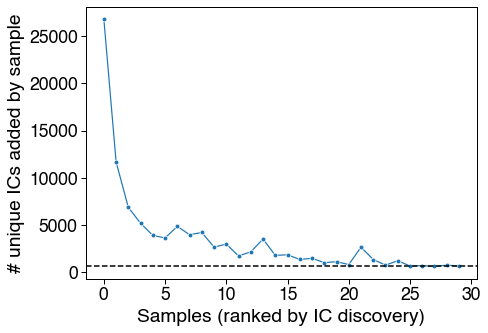

In [122]:
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=big_df,
             x="n_samples",
             y="n_added_uniq", marker="o")
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='# unique ICs added by sample')
plt.axhline(y=big_df.n_added_uniq.min(), color="k",
            linestyle="--", linewidth=1.5, label=f"y = {big_df.n_added_uniq.min()}")
print(big_df.n_added_uniq.min())

[Text(0.5, 0, 'Samples (ranked by IC discovery)'),
 Text(0, 0.5, '# cumulative ICs discovered')]

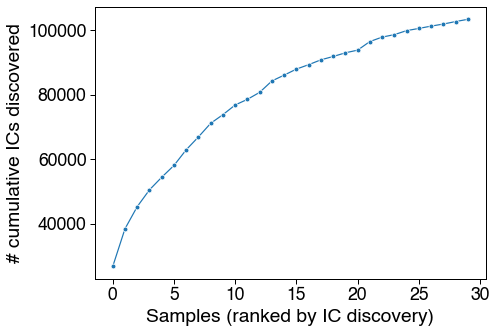

In [123]:
big_df['n_cumulative_ics'] = big_df.n_added_uniq.cumsum()
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=big_df,
             x="n_samples",
             y="n_cumulative_ics", marker="o")
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='# cumulative ICs discovered')

In [124]:
big_df['genome'] = 'pers-hg38'
big_df_pers = big_df.copy(deep=True)

## Only for hg38 

In [125]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
print(len(df.index))
temp = df.loc[(df.structural_category!='full-splice_match')&\
              (df.structural_category!='incomplete-splice_match')]
print(len(temp.index))

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hg38)==1]
temp['n_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')

temp2 = temp[['cell_line_id', 'n_novel_ic']]

12993951
4280955


In [126]:
# get order of samples based on # ics det
temp2 = temp2.sort_values(by='n_novel_ic', ascending=False)
temp2.drop_duplicates(inplace=True)
order = temp2.cell_line_id.tolist()
temp.drop(['hap1', 'hap2', 'hg38', 'n_novel_ic'], axis=1, inplace=True)

# pivot to get isoforms detected per cell lines
temp['detected'] = True
temp = temp.pivot(index='ic_id', columns='cell_line_id')
temp.columns.name = None
temp.columns = temp.columns.get_level_values(1)
temp.fillna(False, inplace=True)

In [127]:
temp = temp[order]
prev_ics = []
big_df = pd.DataFrame()
for i, c in enumerate(temp.columns):
    temp2 = temp.loc[temp[c]==True]
    ics = temp2.index.tolist()
    n = len(list(set(ics)-set(prev_ics)))
    prev_ics += ics
    # print(len(prev_ics))
    temp3 = pd.DataFrame(data=[[n,i]], columns=['n_added_uniq', 'n_samples'])
    big_df = pd.concat([big_df, temp3], axis=0)

613


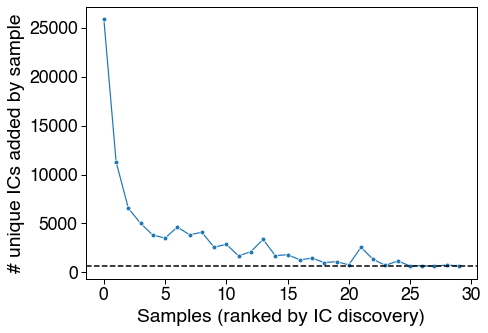

In [128]:
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=big_df,
             x="n_samples",
             y="n_added_uniq", marker="o")
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='# unique ICs added by sample')
plt.axhline(y=big_df.n_added_uniq.min(), color="k",
            linestyle="--", linewidth=1.5, label=f"y = {big_df.n_added_uniq.min()}")
print(big_df.n_added_uniq.min())

[Text(0.5, 0, 'Samples (ranked by IC discovery)'),
 Text(0, 0.5, '# cumulative ICs discovered')]

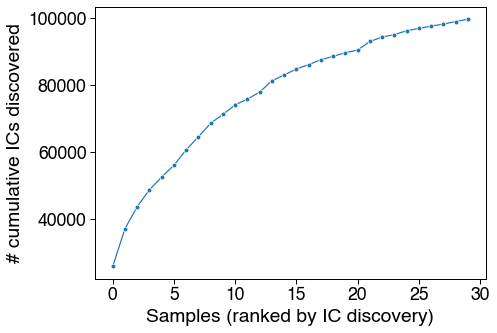

In [129]:
big_df['n_cumulative_ics'] = big_df.n_added_uniq.cumsum()
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=big_df,
             x="n_samples",
             y="n_cumulative_ics", marker="o")
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='# cumulative ICs discovered')

## Compare pers. haps to hg38

In [130]:
big_df['genome'] = 'hg38'
big_df = pd.concat([big_df, big_df_pers], axis=0)

In [131]:
big_df['genome'].unique()

array(['hg38', 'pers-hg38'], dtype=object)

613


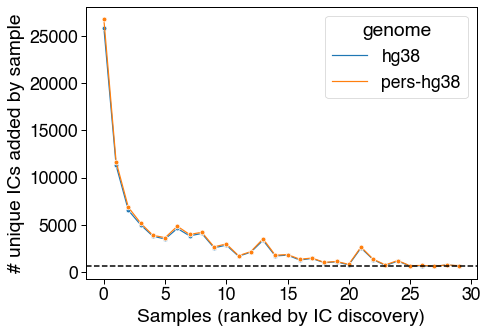

In [132]:
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=big_df,
             x="n_samples",
             y="n_added_uniq", marker="o",
             hue='genome')
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='# unique ICs added by sample')
plt.axhline(y=big_df.n_added_uniq.min(), color="k",
            linestyle="--", linewidth=1.5, label=f"y = {big_df.n_added_uniq.min()}")
print(big_df.n_added_uniq.min())

[Text(0.5, 0, 'Samples (ranked by IC discovery)'),
 Text(0, 0.5, '# cumulative ICs discovered')]

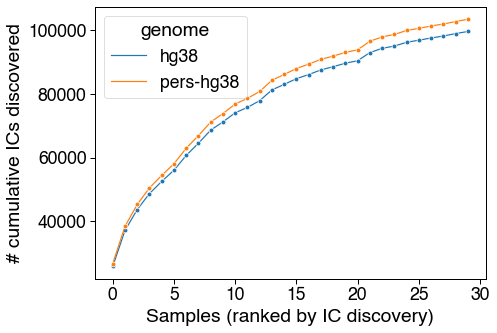

In [133]:
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=big_df,
             x="n_samples",
             y="n_cumulative_ics", marker="o",
             hue='genome')
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='# cumulative ICs discovered')

In [134]:
big_df[['genome', 'n_added_uniq']].groupby('genome').mean()

,n_added_uniq
genome,
hg38,3318.366667
pers-hg38,3445.500000


In [152]:
big_df.head()

,n_added_uniq,n_samples,n_cumulative_ics,genome
0,25851,0,25851,hg38
0,11292,1,37143,hg38
0,6550,2,43693,hg38
0,5019,3,48712,hg38
0,3809,4,52521,hg38


4


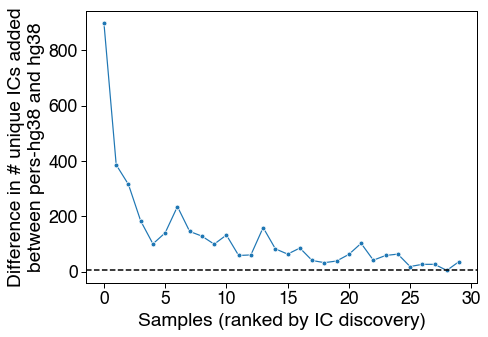

In [158]:
df = big_df[['n_added_uniq', 'n_samples', 'genome']].pivot(index='n_samples', columns='genome').reset_index()
# Assuming df is the DataFrame you provided
df = df.reset_index()  # Move the 'genome' index to columns

# Now, you need to flatten the columns
df.columns = [col[1] if col[0] == 'n_added_uniq' else col[0] for col in df.columns]

# This will create a single-level column with 'n_samples', 'hg38', and 'pers-hg38'
df= df[['n_samples', 'hg38', 'pers-hg38']]
df['diff'] = df['pers-hg38'] - df['hg38']
df.head()
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=df,
             x="n_samples",
             y="diff", marker="o")
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='Difference in # unique ICs added\nbetween pers-hg38 and hg38')
plt.axhline(y=df['diff'].min(), color="k",
            linestyle="--", linewidth=1.5, label=f"y = {df['diff'].min()}")
print(df['diff'].min())

[Text(0.5, 0, 'Samples (ranked by IC discovery)'),
 Text(0, 0.5, 'Difference in # cumulative ICs discovered\nbetween pers-hg38 and hg38')]

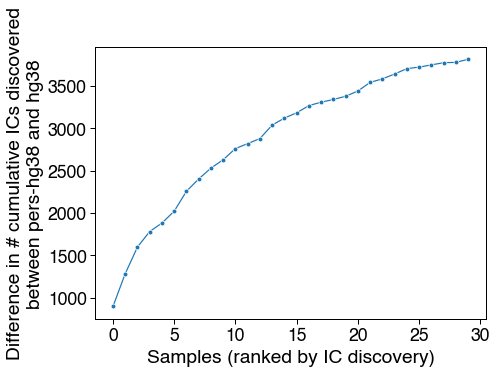

In [151]:
df = big_df[['n_cumulative_ics', 'n_samples', 'genome']].pivot(index='n_samples', columns='genome').reset_index()
# Assuming df is the DataFrame you provided
df = df.reset_index()  # Move the 'genome' index to columns

# Now, you need to flatten the columns
df.columns = [col[1] if col[0] == 'n_cumulative_ics' else col[0] for col in df.columns]

# This will create a single-level column with 'n_samples', 'hg38', and 'pers-hg38'
df= df[['n_samples', 'hg38', 'pers-hg38']]
df['diff'] = df['pers-hg38'] - df['hg38']
df.head()
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=df,
             x="n_samples",
             y="diff", marker="o")
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='Difference in # cumulative ICs discovered\nbetween pers-hg38 and hg38')